# **Image Captioning using VGG-16 and LSTM**

Importing the required dependencies

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

Exploring the dataset

In [ ]:
import os

# Path to the directory you want to check
folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'

# List of file names in the directory
file_list = os.listdir(folder_path)
# Count the number of files
num_files = len(file_list)

print(f"There are {num_files} files in the directory {folder_path}")

There are 82783 files in the directory /kaggle/input/coco-image-caption/train2014/train2014


Directories of the dataset

In [ ]:
image_folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'
caption_folder_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations'

Loading the captions

In [ ]:
captions_data = []
caption_file_path = os.path.join(caption_folder_path, 'captions_train2014.json')

with open(caption_file_path, 'r') as file:
    captions_data = json.load(file)

We are creating a Pandas dataframe of image_id,image path and the corresponding caption

In [ ]:
file_names = []
image_ids = []
captions = []

annotations = captions_data['annotations']
images=captions_data['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}
# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data = {
    'image_id': image_ids,
    'image': file_names,
    'caption': captions

}

data = pd.DataFrame(data)

In [ ]:
data.head(), len(data)

(   image_id                            image  \
 0    318556  COCO_train2014_000000318556.jpg   
 1    116100  COCO_train2014_000000116100.jpg   
 2    318556  COCO_train2014_000000318556.jpg   
 3    116100  COCO_train2014_000000116100.jpg   
 4    379340  COCO_train2014_000000379340.jpg   
 
                                              caption  
 0     A very clean and well decorated empty bathroom  
 1  A panoramic view of a kitchen and all of its a...  
 2  A blue and white bathroom with butterfly theme...  
 3     A panoramic photo of a kitchen and dining room  
 4  A graffiti-ed stop sign across the street from...  ,
 414113)

In **readImage** function we convert the image into RGB format and conerting into a 1D vector and normalize it

We display the first 15 images and then display the captions

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(os.path.join(image_folder_path,temp_df.image[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
directory_path = "/kaggle/input/coco-image-caption/train2014/train2014"
file_list = os.listdir(directory_path)
data = data[data["image"].isin(file_list)]

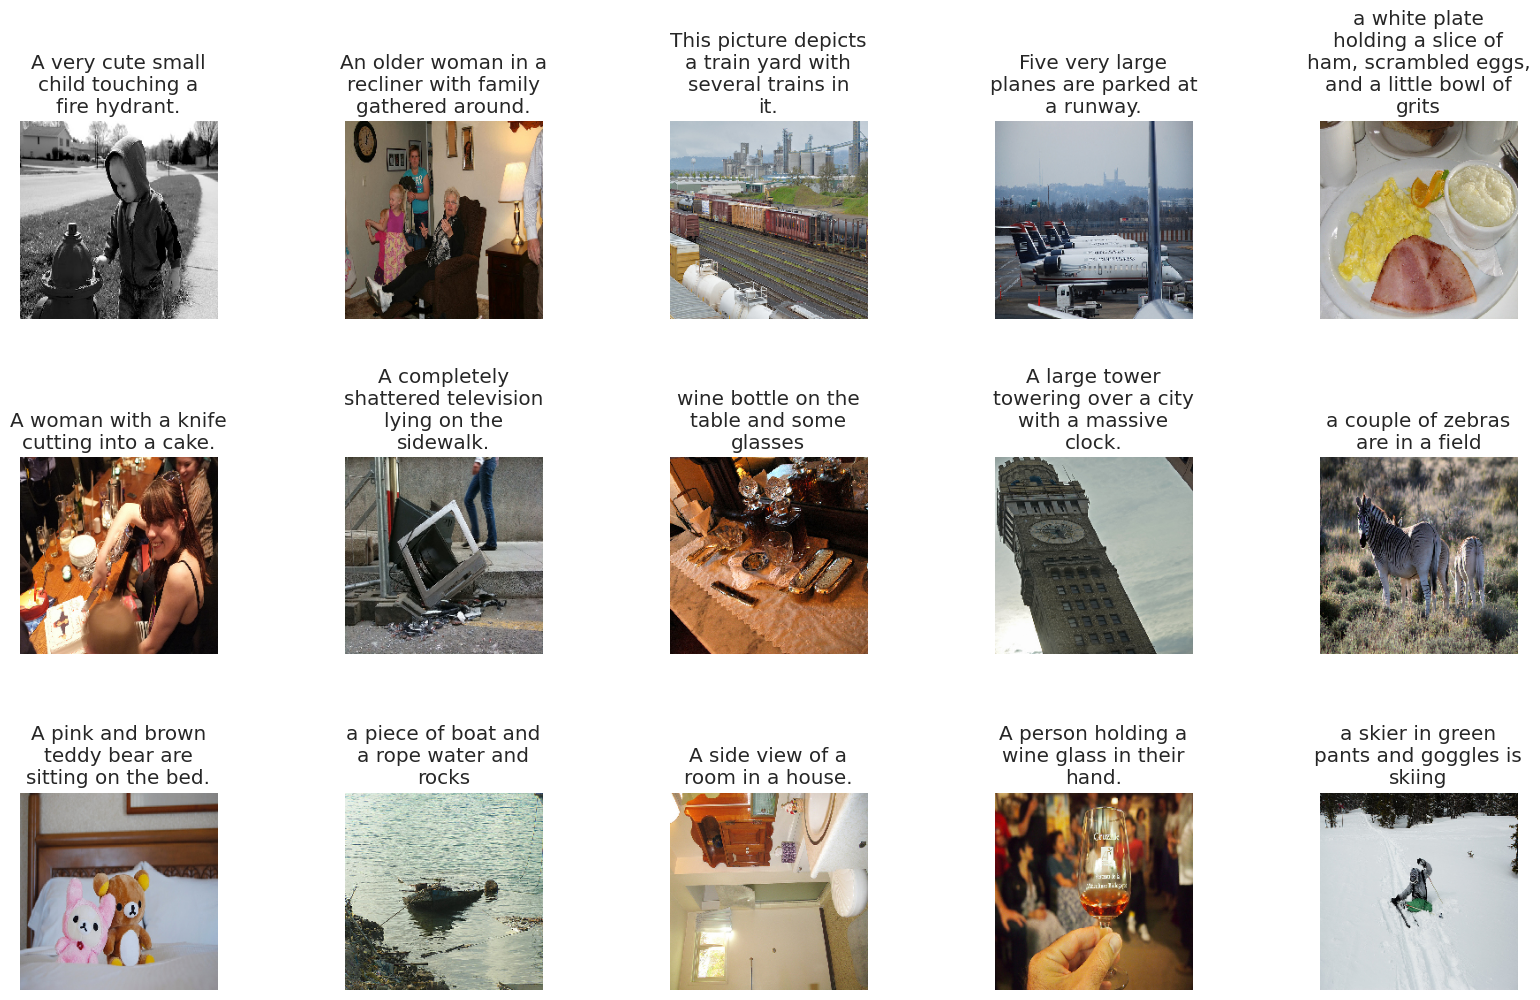

In [ ]:
display_images(data.sample(15))

This **text_preprocessing** function performs several text preprocessing steps on a DataFrame containing caption data

*   Converts all text in the 'caption' column to lowercase. This is done to ensure uniformity in the text and avoid treating the same word differently due to capitalization.

*   Removes any characters that are not alphabetic
*   Replaces multiple consecutive whitespace characters with a single whitespace character.


*   Removes single characters from the captions

*   Adds special tokens "startseq" and "endseq" at the beginning and end of each caption






In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
pip install visualkeras

  Obtaining dependency information for visualkeras from https://files.pythonhosted.org/packages/a5/93/abd375b37add77d58a8c48a506ae39bb77c4380e2507ea444325ff1b9971/visualkeras-0.0.2-py3-none-any.whl.metadata
  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/e4/57/59b42e145ff12941c5c63d59dc48369912a9e29d69966ff630e6f0f815ac/aggdraw-1.3.18.post0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 12.6 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq very clean and well decorated empty bathroom endseq',
 'startseq panoramic view of kitchen and all of its appliances. endseq',
 'startseq blue and white bathroom with butterfly themed wall tiles. endseq',
 'startseq panoramic photo of kitchen and dining room endseq',
 'startseq graffiti-ed stop sign across the street from red car endseq',
 'startseq vandalized stop sign and red beetle on the road endseq',
 'startseq bathroom with border of butterflies and blue paint on the walls above it. endseq',
 'startseq an angled view of beautifully decorated bathroom. endseq',
 'startseq the two people are walking down the beach. endseq',
 'startseq sink and toilet inside small bathroom. endseq']



*   **Tokenizer Initialization and Fitting**:

The tokenizer updates its internal vocabulary based on the text data provided in the captions list. This step tokenizes the captions and constructs a vocabulary based on unique words present in the captions.

*   **Vocabulary Size Calculation**:

The vocab_size variable is assigned the length of the tokenizer's word index plus 1. The tokenizer's word index is a dictionary mapping words to their respective indices.
*  **Maximum Sequence Length Calculation**:

The max_length variable is assigned the maximum length of sequences among all captions in the captions list.


*   **Data Splitting**:

Unique image identifiers are extracted from the 'image' column of the data
The total number of unique images (nimages) is calculated.
 85% of the images are used for training, while the remaining 15% are used for validation.



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 3980, 169, 4, 60, 8, 314, 4, 153, 611, 2]

We are using the VGG16 model to extract the image features.

We are excluding the top_layer for our convenience

In [ ]:
vgg16_model = VGG16(weights='imagenet', include_top=False)
vgg16_model.summary()  # To check the structure of the model

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
import pickle

In [ ]:
!pip install gdown

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/cb/56/f4845ed78723a4eb8eb22bcfcb46e1157a462c78c0a5ed318c68c98f9a79/gdown-5.1.0-py3-none-any.whl.metadata


In [ ]:
!gdown https://drive.google.com/uc?id=1FkbU6QkSaMvOvJ97mRazWmJsAkKelaja

Downloading...
From (original): https://drive.google.com/uc?id=1FkbU6QkSaMvOvJ97mRazWmJsAkKelaja
From (redirected): https://drive.google.com/uc?id=1FkbU6QkSaMvOvJ97mRazWmJsAkKelaja&confirm=t&uuid=380de701-a18b-49a0-b6a0-1ce2606f56a2
To: /kaggle/working/image_featuresvgg16.pkl
100%|███████████████████████████████████████| 5.82G/5.82G [00:57<00:00, 101MB/s]


We are extracting the the precomputed image features of the VGG16 model using the pickle

In [ ]:
# Load the features from the file
with open('/kaggle/working/image_featuresvgg16.pkl', 'rb') as file:
    features = pickle.load(file)

We are making the features as a list

In [ ]:
images_features=list(features.keys())

In [ ]:
filter_image=train["image"].isin(images_features)

We are including only the training and testing images which are matching with image features of the VGG16

In [ ]:
train=train[train["image"].isin(images_features)]

In [ ]:
test=test[test["image"].isin(images_features)]

CustomDataGenerator class helps with the functionality required for generating batches of data for training a model, including loading data, preprocessing, and creating input-output pairs

*   **on_epoch_end** Method:This method is called at the end of each epoch.
If shuffle is True, it shuffles the DataFrame

This method is called at the end of each epoch.

*   **__len__** Method:

Returns the number of batches in the dataset.
It calculates this based on the total number of samples in df and the batch size.
*   **__getitem__** Method:

Generates one batch of data.
It retrieves the rows corresponding to the current batch index and calls the __get_data method to obtain the input features (X1), input sequences (X2), and output labels (y).


*   **__get_data__** Method:

Extracts features for each image in the batch and tokenizes the captions using the provided tokenizer.
Iterates over each caption for each image, generates input-output sequence pairs, pads the input sequence to the maximum length, and converts the output sequence to one-hot encoded format.



In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y



1.   **Feature Extractor Model**: This part defines a feature extractor model that processes image features.


*   input_a: Defines an input tensor with shape (7, 7, 512), representing a feature map extracted from an image using a convolutional neural network (CNN).

*   GlobalAveragePooling2D()(input_a): Applies global average pooling to the input feature map, reducing its spatial dimensions to a fixed-size vector.


*   Dense(256, activation='relu')(a1): Adds a fully connected (dense) layer with 256 units and ReLU activation



2.   **Sequence Model**: This part defines a sequence model that processes textual input.


*   input_b: Defines an input tensor with shape (max_length,), where max_length is the maximum length of a sequence.


*   Embedding(vocab_size, 256, mask_zero=True)(input_b): Applies an embedding layer, mapping each word index to a dense vector representation. The layer has vocab_size units and generates dense embeddings of size 256. mask_zero=True is used to mask padding tokens in sequences.



*   LSTM(256)(b1): Applies an LSTM (Long Short-Term Memory) layer with 256 units to process the embedded sequences.

3. **Decoder Model**: This part combines the outputs from the feature extractor and sequence models and predicts the next word in the sequence.


*   add([a2, b2]): Adds the outputs from the feature extractor and sequence models element-wise.

*   Dense(256, activation='relu')(decoder1): Adds a fully connected layer with 256 units and ReLU activation to further process the combined features.




*   Dense(vocab_size, activation='softmax')(decoder2): Adds a fully connected layer with vocab_size units and softmax activation to output the probability distribution over the vocabulary, predicting the next word in the sequence.






In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Feature extractor model
input_a = Input(shape=(7, 7, 512))
a1 = GlobalAveragePooling2D()(input_a)
a2 = Dense(256, activation='relu')(a1)

# Sequence model
input_b = Input(shape=(max_length,))
b1 = Embedding(vocab_size, 256, mask_zero=True)(input_b)
b2 = LSTM(256)(b1)

# Decoder model
decoder1 = add([a2, b2])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Tie it together [image, seq] [word]
model = Model(inputs=[input_a, input_b], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

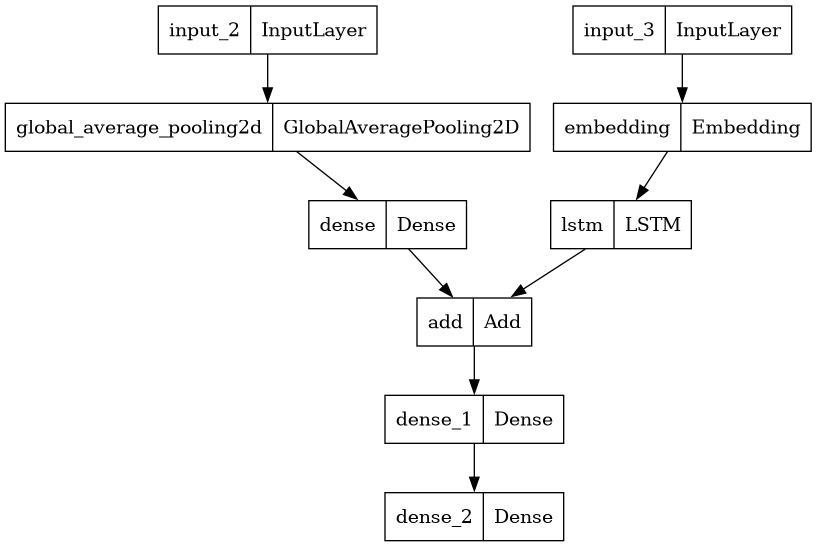

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 7, 7, 512)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 49)]                 0         []                            
                                                                                                  
 global_average_pooling2d (  (None, 512)                  0         ['input_2[0][0]']             
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 embedding (Embedding)       (None, 49, 256)              6063104   ['input_3[0][0]']         

Feeding the training and validation dataset to the model

In [ ]:
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_folder_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_folder_path,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)



1.   **ModelCheckpoint**:
ModelCheckpoint saves model weights during training.
It monitors val_loss to save weights when it's minimized.
save_best_only=True ensures only best weights on validation set are saved, and verbose=1 prints a message when saved.
2.   **EarlyStopping**: EarlyStopping halts training when monitored metric stops improving.
It tracks val_loss, considering changes less than min_delta.
After patience epochs with no improvement, training stops.
If restore_best_weights=True, it reloads weights for the best performance.

3. **ReduceLROnPlateau**: ReduceLROnPlateau adjusts learning rate when monitored metric plateaus.
It observes val_loss for changes over patience epochs.
When no improvement is seen, the learning rate is decreased by a factor of 0.2.
A lower bound for the learning rate is set at 0.00000001, and a message is printed when it's reduced.





In [ ]:
model_name = "model_AllDatavgg16.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)


The model.fit() function trains the model.
It specifies train_generator as the training data source.
runs for 5 epochs.
Validation data is provided through validation_generator, and callbacks for checkpointing, early stopping, and learning rate reduction are applied.

In [ ]:
history = model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/5
3854/3854 [==============================] - ETA: 0s - loss: 3.8744
Epoch 1: val_loss improved from inf to 3.68369, saving model to model_AllDatavgg16.h5
3854/3854 [==============================] - 2073s 536ms/step - loss: 3.8744 - val_loss: 3.6837 - lr: 0.0010
Epoch 2/5
3854/3854 [==============================] - ETA: 0s - loss: 3.0946
Epoch 2: val_loss improved from 3.68369 to 3.48596, saving model to model_AllDatavgg16.h5
3854/3854 [==============================] - 1351s 350ms/step - loss: 3.0946 - val_loss: 3.4860 - lr: 0.0010
Epoch 3/5
3854/3854 [==============================] - ETA: 0s - loss: 2.8809
Epoch 3: val_loss improved from 3.48596 to 3.48402, saving model to model_AllDatavgg16.h5
3854/3854 [==============================] - 1345s 349ms/step - loss: 2.8809 - val_loss: 3.4840 - lr: 0.0010
Epoch 4/5
3854/3854 [==============================] - ETA: 0s - loss: 2.7530
Epoch 4: val_loss did not improve from 3.48402
3854/3854 [==============================] - 134

In [ ]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


Now we are taking any random 15 images from our image_folder and try to predict the caption using the **generate_captions()** method

For each image feature provided in the image_features list:


*   Initialize the input sequence with the 'startseq' token.
Iterate over each word in the caption until either the maximum length is reached or the 'endseq' token is predicted.


*   For each iteration, convert the input sequence into numerical sequence representation using the tokenizer.
Pad the numerical sequence to match the maximum length.

*   Use the model to predict the next word in the sequence based on the current input sequence.



*   Convert the predicted word index back to its corresponding word using the tokenizer.



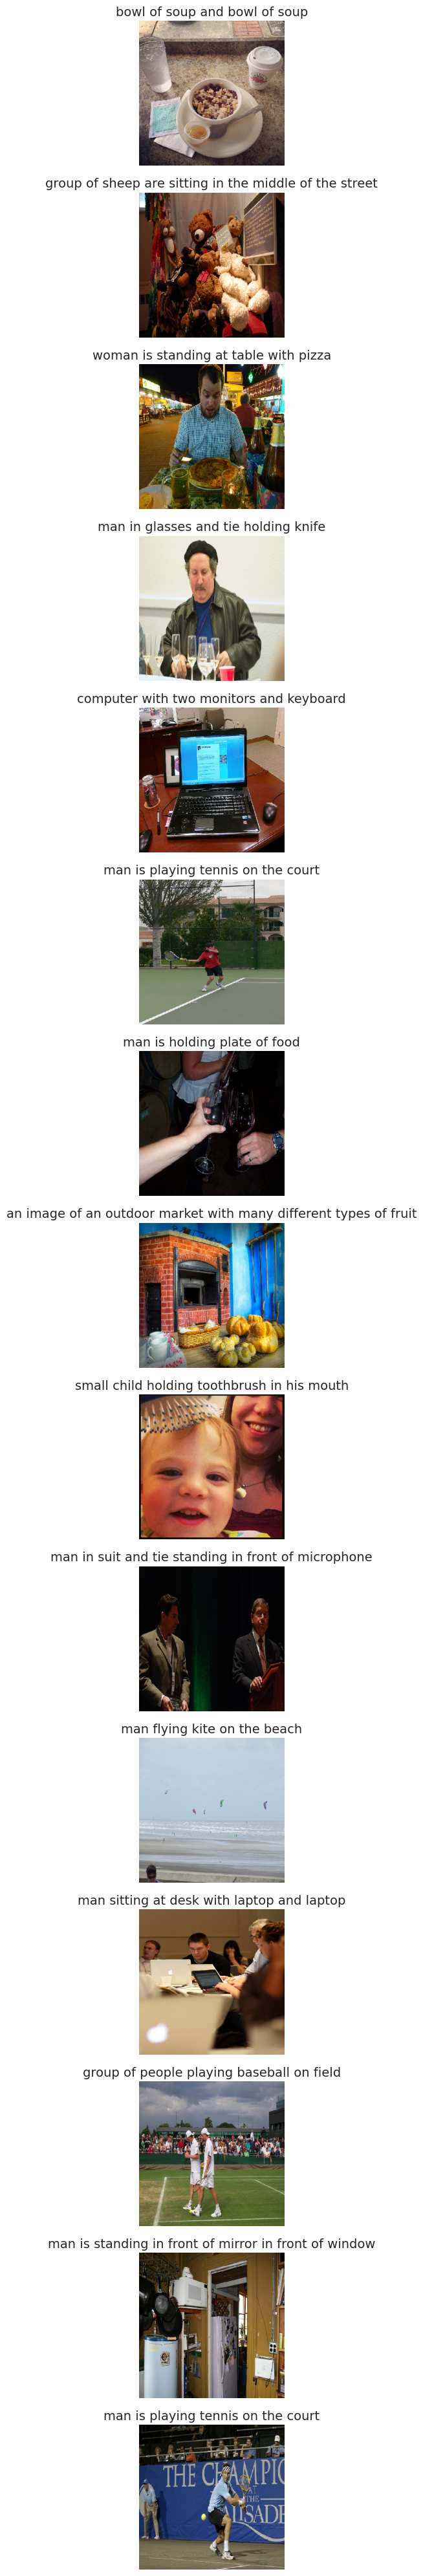

In [ ]:
# Load the trained model
from tensorflow.keras.models import load_model
model = load_model("model_AllDatavgg16.h5")

# Function to generate captions for images
def generate_captions(model, image_features, tokenizer, max_length):
    start_seq = tokenizer.word_index['startseq']
    end_seq = tokenizer.word_index['endseq']
    caption_list = []
    for feature in image_features:
        input_seq = 'startseq'
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([input_seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            prediction = model.predict([np.array([feature]), np.array(sequence)], verbose=0)
            prediction = np.argmax(prediction)
            word = ''
            for key, value in tokenizer.word_index.items():
                if value == prediction:
                    word = key
                    break
            if word is None:
                break
            if word == 'endseq':
                break
            input_seq += ' ' + word
        caption_list.append(input_seq)
    return caption_list

# Select 10 random images for captioning and display
sample_images = test.sample(15)
sample_image_paths = [os.path.join(image_folder_path, image_name) for image_name in sample_images['image']]
sample_image_features = [features[image_name][0] for image_name in sample_images['image']]
sample_captions = generate_captions(model, sample_image_features, tokenizer, max_length)

# Display images with their generated captions
plt.figure(figsize=(20, 40))  # Adjust figure size for one image per row and increased image dimensions
for i in range(15):
    plt.subplot(15, 1, i+1)  # Adjust subplot arrangement for one image per row
    image = load_img(sample_image_paths[i], target_size=(400, 400))  # Increase image dimensions
    plt.imshow(image)
    # Split the caption string by space and remove 'startseq' token
    caption_words = sample_captions[i].split()[1:]  # Exclude startseq
    plt.title(' '.join(caption_words), fontsize=14)  # Join the words to form the caption
    plt.axis('off')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [ ]:
!jupyter nbconvert --to html /content/Image_Captioning.ipynb

[NbConvertApp] Converting notebook /content/Image_Captioning.ipynb to html
[NbConvertApp] Writing 4718711 bytes to /content/Image_Captioning.html
